In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [92]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz
import dtreeviz
import IPython
from xgboost import XGBClassifier
import xgboost as xgb
import graphviz
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20

In [4]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()

In [5]:
comp = 'playground-series-s3e17'
path = URLs.path(comp)
path

Path('C:/Users/adima/.fastai/archive/playground-series-s3e17')

In [6]:
from kaggle import api

if not path.exists():
    path.mkdir(parents = true)
    api.competition_download_cli(comp, path = path)
    shutil.unpack_archive(str(path/f'{comp}.zip'),str(path))

In [7]:
path/'train.csv'

Path('C:/Users/adima/.fastai/archive/playground-series-s3e17/train.csv')

In [127]:
df = pd.read_csv(path/'train.csv', low_memory =False)

In [128]:
pd.options.display.max_columns = 14

In [129]:
df.shape

(136429, 14)

In [130]:
df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [131]:
df[df['Machine failure']==1]

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
130,130,L52498,L,303.9,312.8,1345,56.5,21,1,0,0,0,0,0
164,164,L51721,L,302.5,310.4,1307,54.8,174,1,0,1,0,0,0
228,228,M17895,M,300.7,309.7,1878,27.9,20,1,0,0,0,0,0
236,236,L55926,L,297.3,308.6,1258,61.8,144,1,0,0,0,1,0
247,247,L51801,L,303.0,311.3,1341,51.0,174,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135902,135902,L52669,L,302.6,312.1,1638,35.0,215,1,1,0,0,0,0
135917,135917,L56200,L,297.3,308.2,1553,33.5,208,1,1,0,0,0,0
135957,135957,L55410,L,299.1,310.6,1353,49.7,74,1,0,0,0,0,0
136053,136053,H34965,H,302.4,312.0,1286,62.3,162,1,0,0,1,0,0


In [132]:
df_test = pd.read_csv(path/'test.csv', low_memory =False)

In [133]:
df_test.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [134]:
df[(df['Product ID'] == 'M19751') & (df['Machine failure'] == 0)]

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
1133,1133,M19751,M,303.7,312.3,1456,43.9,94,0,0,0,0,0,0
4234,4234,M19751,M,303.7,312.3,1546,34.6,166,0,0,0,0,0,0
6104,6104,M19751,M,303.7,312.4,1525,43.9,188,0,0,0,0,0,0
10072,10072,M19751,M,303.7,312.3,1535,39.8,187,0,0,0,0,0,0
15063,15063,M19751,M,303.7,312.4,1525,43.3,129,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124608,124608,M19751,M,303.7,312.3,1356,53.3,190,0,0,0,0,0,0
126555,126555,M19751,M,303.7,312.3,1435,45.9,0,0,0,0,0,0,0
128985,128985,M19751,M,303.7,312.3,1610,33.7,190,0,0,0,0,0,0
131292,131292,M19751,M,303.7,312.3,1336,53.9,188,0,0,0,0,0,0


In [135]:
dep_var = 'Machine failure'

In [136]:
procs = [Categorify, FillMissing]

In [137]:
cont,cat = cont_cat_split(df, 2, dep_var=dep_var)

In [138]:
cont.remove('id')

In [139]:
cont

['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]']

In [140]:
cat

['Product ID', 'Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

In [141]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits = RandomSplitter(valid_pct=0.2)(range_of(df)))

In [29]:
to.show()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
97952,L54230,L,300.600006,310.500000,1416,44.099998,146,0
33145,L53856,L,301.500000,310.700012,1427,44.000000,104,0
84602,L50947,L,302.299988,311.100006,1446,35.599998,183,0
104673,L48726,L,298.399994,308.899994,1488,38.900002,100,0
100257,H29990,H,297.700012,309.700012,1440,51.200001,146,0
103863,L50393,L,300.399994,309.200012,1408,47.900002,52,0
114104,L53474,L,301.200012,310.500000,1529,38.700001,64,0
132523,L50755,L,301.700012,310.600006,1567,42.500000,114,0
27364,L53562,L,300.100006,309.700012,1397,45.799999,64,0
97985,H34769,H,303.299988,312.500000,1328,49.799999,49,0


In [30]:
len(to.train),len(to.valid)

(109144, 27285)

In [163]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [32]:
m = DecisionTreeClassifier(max_leaf_nodes = 4)
m.fit(xs,y)

DecisionTreeClassifier(max_leaf_nodes=4)

In [63]:
samp_idx = np.random.permutation(len(y))[:500]

In [34]:
viz = dtreeviz.model(m, xs.iloc[samp_idx] , y.iloc[samp_idx], feature_names =  xs.columns, target_name= dep_var)

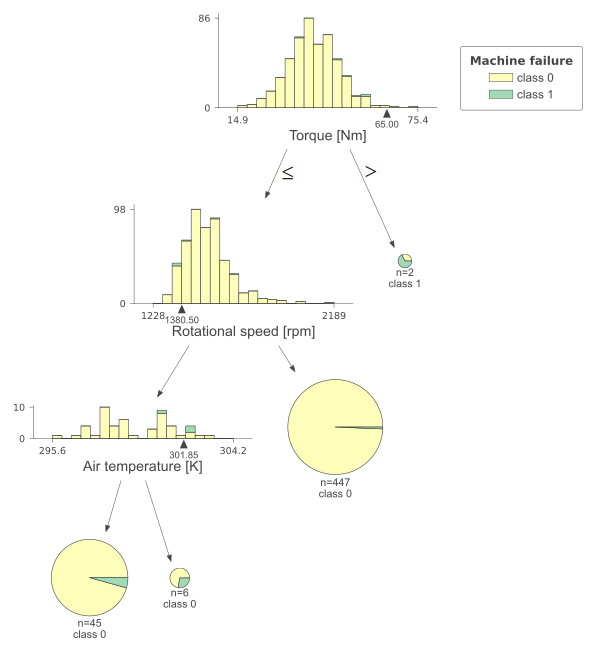

In [37]:
viz.view(scale=1.6)

In [38]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """Draws a representation of a random forest in IPython."""
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

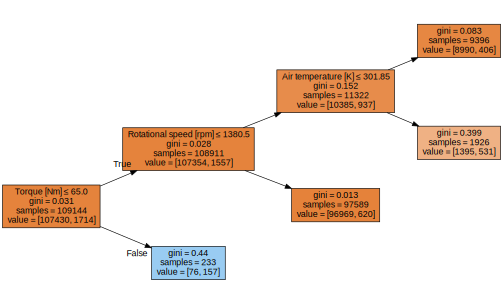

In [39]:
draw_tree(m, xs, size=7, precision =3)

In [74]:
## The One hot encoded values are changed from 0,1 to 1,2

In [143]:
x=xs.iloc[1]
x

Product ID                 7659.000000
Type                          3.000000
TWF                           1.000000
HDF                           1.000000
PWF                           1.000000
OSF                           1.000000
RNF                           1.000000
Air temperature [K]         299.399994
Process temperature [K]     308.600006
Rotational speed [rpm]     1316.000000
Torque [Nm]                  62.700001
Tool wear [min]             156.000000
Name: 105742, dtype: float32

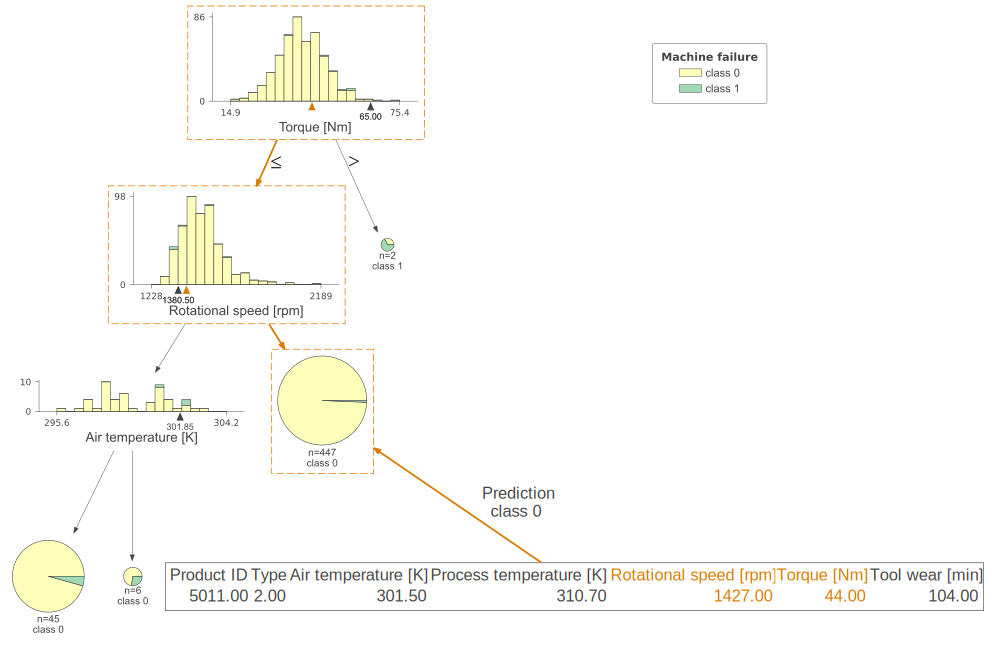

In [41]:
viz.view(scale=1.5, x=x)

In [42]:
from sklearn.metrics import roc_auc_score  ## The evaluation metric that is used in the Competition is AUC ROC

In [43]:
pred_prob1 = m.predict_proba(valid_xs)

In [44]:
auc_score1 = roc_auc_score(valid_y, pred_prob1[:,1])
auc_score1

0.7947828921748918

In [102]:
def rf(xs, y, n_estimators=100, max_samples=100_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [103]:
m = rf(xs,y)

In [104]:
pred_prob1 = m.predict_proba(valid_xs)

In [105]:
auc_score1 = roc_auc_score(valid_y, pred_prob1[:,1])
auc_score1

0.9384132472303636

In [49]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

C:\Users\adima\anaconda3\envs\d2l\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
C:\Users\adima\anaconda3\envs\d2l\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
C:\Users\adima\anaconda3\envs\d2l\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
C:\Users\adima\anaconda3\envs\d2l\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
C:\Users\adima\anaconda3\envs\d2l\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
C:\Users\adima\anaconda3\envs\d2l\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature name

In [50]:
preds.shape

(40, 27285)

In [53]:
preds_std = preds.std(0)
preds_std[:40]

array([0.        , 0.        , 0.        , 0.        , 0.46837485,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.15612495,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [54]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [55]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
5,Torque [Nm],0.271834
4,Rotational speed [rpm],0.198731
0,Product ID,0.153398
2,Air temperature [K],0.134680
6,Tool wear [min],0.130491
3,Process temperature [K],0.103487
1,Type,0.007377


In [56]:
xs.shape[0]

109144

In [181]:
def predict_machine_failure(xs):
    preds =[]
    for i in range(xs.shape[0]):
        if (xs.iloc[i].TWF == 2.0) | (xs.iloc[i].HDF == 2.0) | (xs.iloc[i].PWF == 2.0) | (xs.iloc[i].OSF == 2.0) | (xs.iloc[i].RNF == 2.0):
            preds.append(1)
        else: 
            preds.append(0)
    return preds

In [182]:
xs.iloc[124].TWF

2.0

In [183]:
print(list(np.where(xs["TWF"] == 2)))

[array([   124,    729,   1325,   1592,   1791,   2403,   3494,   4339,
         4425,   5408,   5676,   6065,   6292,   6799,   7523,   7906,
         8481,   9250,  10903,  11817,  12446,  12450,  13214,  13340,
        13937,  13961,  14017,  14202,  14304,  15896,  16158,  17754,
        18114,  18731,  20269,  20464,  21762,  22521,  22581,  22590,
        22839,  23088,  23426,  23471,  24405,  25013,  25361,  25397,
        25819,  26545,  28736,  32631,  33386,  33642,  35114,  35225,
        36323,  36510,  36884,  36930,  38212,  38731,  39077,  39189,
        39587,  40621,  40714,  41808,  42164,  43216,  43574,  43642,
        45006,  45067,  45314,  46499,  47066,  47096,  48195,  48270,
        48571,  48635,  48841,  49638,  50524,  51676,  53032,  54065,
        54694,  54821,  54934,  56568,  56603,  57693,  57866,  58904,
        58982,  59691,  59800,  60542,  60795,  62266,  63290,  65740,
        67410,  67458,  68628,  68673,  69179,  69204,  69481,  69646,
     

In [204]:
preds = predict_machine_failure(valid_xs)

In [196]:
indices = [i for i, x in enumerate(preds) if x == 1]

In [197]:
indices

[136,
 165,
 275,
 285,
 310,
 351,
 458,
 803,
 852,
 890,
 892,
 1040,
 1051,
 1430,
 1513,
 1565,
 1593,
 1655,
 1676,
 1783,
 1949,
 2089,
 2093,
 2363,
 2390,
 2431,
 2592,
 2653,
 2813,
 2871,
 2915,
 2971,
 3058,
 3145,
 3234,
 3310,
 3315,
 3325,
 3330,
 3350,
 3372,
 3406,
 3480,
 3481,
 3484,
 3682,
 3717,
 3818,
 3983,
 4085,
 4151,
 4159,
 4201,
 4227,
 4261,
 4316,
 4418,
 4597,
 4659,
 4729,
 4760,
 4775,
 4884,
 5095,
 5147,
 5173,
 5184,
 5233,
 5296,
 5382,
 5421,
 5441,
 5510,
 5536,
 5580,
 5592,
 5631,
 5824,
 5844,
 5860,
 6003,
 6038,
 6055,
 6090,
 6159,
 6222,
 6226,
 6232,
 6257,
 6342,
 6368,
 6412,
 6429,
 6492,
 6598,
 6613,
 6703,
 6723,
 6748,
 6849,
 6896,
 6905,
 6951,
 7216,
 7246,
 7314,
 7332,
 7580,
 7602,
 7653,
 7720,
 7730,
 7809,
 7999,
 8106,
 8254,
 8335,
 8356,
 8529,
 8802,
 8873,
 8994,
 9082,
 9254,
 9380,
 9581,
 9587,
 9599,
 9752,
 9999,
 10098,
 10241,
 10335,
 10386,
 10387,
 10465,
 10504,
 10560,
 10596,
 10867,
 10956,
 10964,
 1103

In [205]:
preds = pd.Series(preds)

In [206]:
preds.iloc[136]

1

In [207]:
valid_y.iloc[136]

1

In [210]:
def mse(preds,y):
    return round(math.sqrt(((preds-y)**2).mean()), 6)

In [211]:
mse(preds,y)

0.16664

In [213]:
cont,cat = cont_cat_split(df_test, 2, dep_var=dep_var)

In [160]:
to_test = TabularPandas(df_test, procs, cat, cont)

In [162]:
test_xs = to_test.train.xs

In [116]:
df_test.id

0        136429
1        136430
2        136431
3        136432
4        136433
          ...  
90949    227378
90950    227379
90951    227380
90952    227381
90953    227382
Name: id, Length: 90954, dtype: int64

In [233]:
preds = predict_machine_failure(xs)

In [254]:
type(preds)

numpy.ndarray

In [255]:
output = pd.DataFrame({
"id": df_test["id"],
"Machine failure": preds})

In [174]:
def create_submittion_file(preds):
    output = pd.DataFrame({
        "id": df_test["id"],
        "Machine failure": preds})
    output.to_csv('my_submission_xgboost_proba.csv', index=False)

In [256]:
output

,id,Machine failure
0,136429,0
1,136430,0
2,136431,0
3,136432,0
4,136433,0
...,...,...
90949,227378,0
90950,227379,0
90951,227380,0
90952,227381,0


In [257]:
output.to_csv('my_submission_Random_Forest.csv', index=False)

In [252]:
preds = m.predict(to_test.train.xs)

## Trying out xgboost and other boosting methods with no failure mode columns

In [166]:
xs = xs.rename(columns={'Air temperature [K]': 'Air temperature', 'Process temperature [K]': 'Process temperature',
                   'Rotational speed [rpm]':'Rotational speed', 'Torque [Nm]':'Torque', 'Tool wear [min]':'Tool wear'})

In [145]:
valid_xs = valid_xs.rename(columns={'Air temperature [K]': 'Air temperature', 'Process temperature [K]': 'Process temperature',
                   'Rotational speed [rpm]':'Rotational speed', 'Torque [Nm]':'Torque', 'Tool wear [min]':'Tool wear'})

In [146]:
test_xs = to_test.train.xs

In [167]:
test_xs = to_test.train.xs.rename(columns={'Air temperature [K]': 'Air temperature', 'Process temperature [K]': 'Process temperature',
                   'Rotational speed [rpm]':'Rotational speed', 'Torque [Nm]':'Torque', 'Tool wear [min]':'Tool wear'})

In [148]:
xgb_model = XGBClassifier()
xgb_model.fit(xs, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [149]:
viz_model = dtreeviz.model(xgb_model, tree_index=0,
                           X_train=xs, y_train=y,
                           feature_names=xs.columns.tolist(),
                           target_name=dep_var)

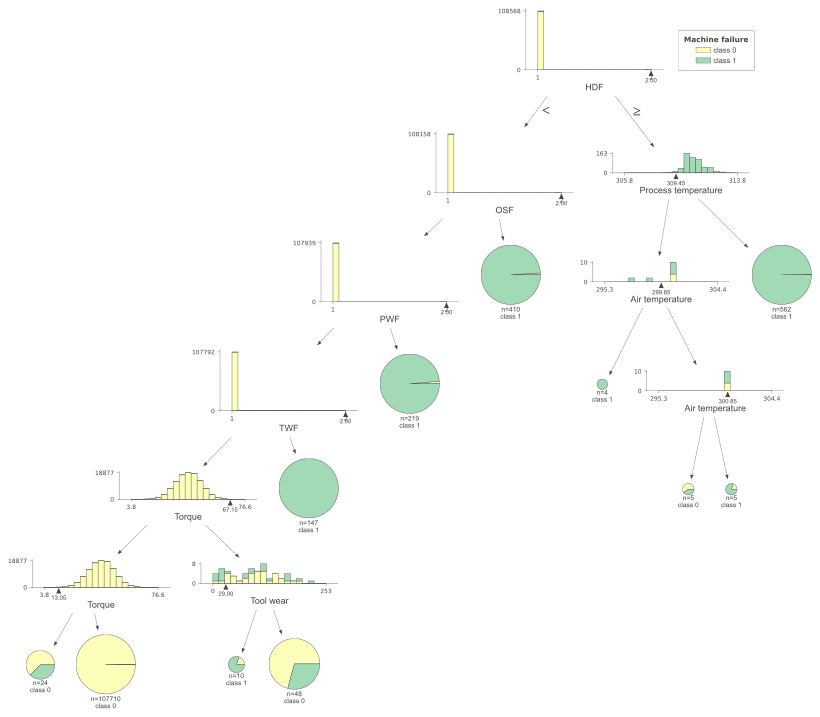

In [150]:
viz_model.view()

In [79]:
## Looks highly specefic

In [151]:
fi = rf_feat_importance(xgb_model, xs)
fi[:10]

,cols,imp
3,HDF,0.429180
5,OSF,0.261424
4,PWF,0.152127
2,TWF,0.111599
9,Rotational speed,0.009279
10,Torque,0.009083
11,Tool wear,0.007591
7,Air temperature,0.006709
8,Process temperature,0.006435
0,Product ID,0.005889


In [88]:
def auc_roc_score(m,xs,y):    
    pred_prob1 = m.predict_proba(xs)
    auc_score1 = roc_auc_score(y, pred_prob1[:,1])
    return auc_score1

In [152]:
auc_roc_score(xgb_model,valid_xs,valid_y)

0.9643521401589836

In [99]:
params = {'objective':'binary:logistic',
          'max_depth': 6,
          'colsample_bylevel':0.5,
          'learning_rate':0.1,
          'random_state':20
         }

In [155]:
xgb_model_with_params = xgb.XGBClassifier(objective='binary:logistic', max_depth =6,
                                         colsample_bytree=0.5, learning_rate=0.1)

In [156]:
xgb_model_with_params.fit(xs, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [94]:
dmatrix = xgb.DMatrix(data=xs, label=y)

In [100]:
cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics={'auc'}, as_pandas=True, seed=20, num_boost_round=1000)

In [101]:
print('AUC: %.2f' % cv_results['test-auc-mean'].min())

AUC: 0.81


In [106]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

In [108]:
from sklearn.model_selection import GridSearchCV
xgbr = xgb.XGBClassifier(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='roc_auc', 
                   verbose=1)

In [120]:
to_test.train.xs

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,3204,2,302.299988,311.500000,1499,38.000000,60
1,4987,2,301.700012,311.000000,1713,28.799999,17
2,2959,2,301.299988,310.399994,1525,37.700001,96
3,8829,3,300.100006,309.600006,1479,47.599998,5
4,8369,3,303.399994,312.299988,1515,41.299999,114
...,...,...,...,...,...,...,...
90949,3333,2,302.299988,311.399994,1484,40.400002,15
90950,1348,2,297.899994,309.799988,1542,33.799999,31
90951,1534,2,295.600006,306.200012,1501,41.400002,187
90952,2041,2,298.100006,307.799988,1534,40.299999,69


In [164]:
test_xs

,Product ID,Type,TWF,HDF,PWF,OSF,RNF,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,3204,2,1,1,1,1,1,302.299988,311.500000,1499,38.000000,60
1,4987,2,1,1,1,1,1,301.700012,311.000000,1713,28.799999,17
2,2959,2,1,1,1,1,1,301.299988,310.399994,1525,37.700001,96
3,8829,3,1,1,1,1,1,300.100006,309.600006,1479,47.599998,5
4,8369,3,1,1,1,1,1,303.399994,312.299988,1515,41.299999,114
...,...,...,...,...,...,...,...,...,...,...,...,...
90949,3333,2,1,1,1,1,1,302.299988,311.399994,1484,40.400002,15
90950,1348,2,1,1,1,1,1,297.899994,309.799988,1542,33.799999,31
90951,1534,2,1,1,1,1,1,295.600006,306.200012,1501,41.400002,187
90952,2041,2,1,1,1,1,1,298.100006,307.799988,1534,40.299999,69


In [173]:
preds = xgb_model.predict_proba(test_xs)

In [176]:
(preds)

array([[9.9951428e-01, 4.8570716e-04],
       [9.9739546e-01, 2.6045288e-03],
       [9.9987280e-01, 1.2719116e-04],
       ...,
       [9.9962020e-01, 3.7982373e-04],
       [9.9958014e-01, 4.1985555e-04],
       [9.9790651e-01, 2.0935067e-03]], dtype=float32)

In [175]:
create_submittion_file(preds)

ValueError: Per-column arrays must each be 1-dimensional

## XGBoost with all columns

In [157]:
auc_roc_score(xgb_model_with_params,valid_xs,valid_y)

0.9699782558918528

In [172]:
preds = xgb_model_with_params.predict(test_xs)
create_submittion_file(preds)